<a href="https://colab.research.google.com/github/dodonas/DL_Final_Project_GAN/blob/master/DL_FINAL_PROJECT_Conditional_GAN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks - Afeka, Deep Learning
# Final project - Implementing Conditional GANs in Keras

# Submitters

[Andrey Dodon](https://www.kaggle.com/andreydodon) - ID 317858298

[Pazit Lazar](https://il.linkedin.com/in/pazit-lazar-85012272) - ID 204059919

[Erez Mahalu](https://il.linkedin.com/in/erez-mahalu-589388109) - ID 305465619

[Ekaterina Natanov](https://il.linkedin.com/in/ekaterina-natanov-0960135a) - ID 323281758

# References
[Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)<br> 
[Domain Transfer - Weizmann Institute of Science](https://www.wisdom.weizmann.ac.il/~vision/courses/2018_2/Advanced_Topics_in_Computer_Vision/files/DomainTransfer.pdf)


# Short introduction

Regular GAN that generates images using a random latent vector as input.<br>
While it works great we do not know the mapping of latent vector to the generated image.<br> Conditional GANs can be used to supply a label during taining so the latent vector can be associated <br> with a specific label - making the generation of images predictable. 

# Quick reminder
As discussed during the ZOOM presentation, the GAN is made up of two different neural networks: the Discriminator and the Generator.  The generator generates the images, while the discriminator detects if a face is real or was generated.  These two neural networks work as shown below:<br>
![GAN](https://raw.githubusercontent.com/dodonas/DL_Final_Project_GAN/master/data/img/gan_flow.png "GAN architecture")

The discriminator accepts an image as its input and produces number that is the probability of the input image being real.  The generator accepts a random seed vector and generates an image from that random vector seed. An unlimited number of new images can be created by providing additional seeds.

# What is Conditional GAN?

CGAN Generator: G(z, y) = x*|y. Using random noise vector z and label y as inputs,<br> the Generator produces a fake example x*|y that strives to be a realistic-looking match for the label.<br>
![cGAN_generator](https://drek4537l1klr.cloudfront.net/langr/Figures/08fig01.jpg "cGAN generator")

The CGAN Discriminator receives real examples along with their labels (x, y)<br> and fake examples along with the label used to synthesize them (x*|y, y). <br>The Discriminator then outputs a probability (computed by the sigmoid activation function σ) <br>indicating whether the input pair is real rather than fake.

![cGAN_discriminator](https://drek4537l1klr.cloudfront.net/langr/Figures/08fig02_alt.jpg "cGAN discriminator")

# Imports

In [1]:
import numpy as np
import seaborn as sb
import tensorflow as tf
import pandas as pd
import json
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.layers import Flatten, BatchNormalization, Embedding
from tensorflow.keras.layers import Activation, ZeroPadding2D, Concatenate
from tensorflow.keras.layers import LeakyReLU, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
%matplotlib inline

# Load data and plot to get a quick understanding

## CIFAR-10
[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)<br>
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes,<br> with 6000 images per class.<br> There are 50000 training images and 10000 test images.<br>
CIFAR10 classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

170508288/170498071 [==============================] - 3s 0us/step


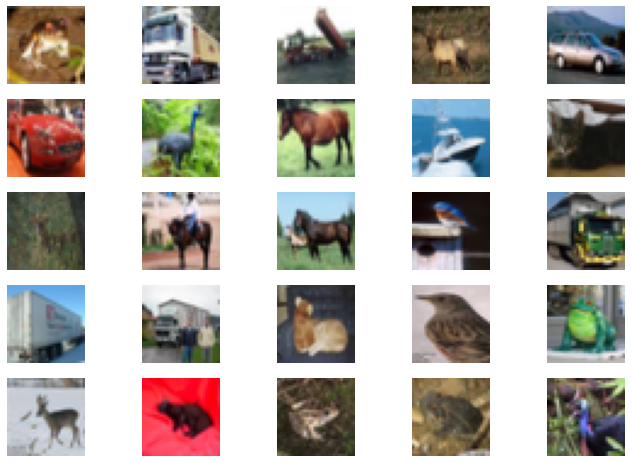

In [30]:
(trainX, trainy), (testX, testy) = load_data()
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
# plot 25 images
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

# Implementations

Next we actually build the discriminator and the generator.<br>The Descriminator will be trained with the Adam optimizer.<br>Adam optimization is a stochastic gradient descent method that is based<br>on adaptive estimation of first-order and second-order moments.<br>According to [Kingma et al., 2014](http://arxiv.org/abs/1412.6980), the method is "computationally efficient,<br>has little memory requirement, invariant to diagonal rescaling of gradients,<br>and is well suited for problems that are large in terms of data/parameters".

## Descriminator
Given an input image, the Discriminator outputs the likelihood of the image being real<br>
Binary classification - true or false (1 or 0). So using sigmoid activation.<br>
Unlike regular GAN here we are also providing number of classes as input.<br>
Input to the model will be both images and labels.

In [31]:
def get_discriminator(in_shape=(32,32,3), n_classes=10):
  # label input
	in_label = Input(shape=(1,))  #Shape 1
	# embedding for categorical input
  #each label (total 10 classes for cifar), will be represented by a vector of size 50. 
  #This vector of size 50 will be learnt by the discriminator
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]  #32x32 = 1024. 
	li = Dense(n_nodes)(li)  #Shape = 1, 1024
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1
	# image input
	in_image = Input(shape=in_shape) #32x32x3
	# concat label as a channel
	merge = Concatenate()([in_image, li]) #32x32x4 (4 channels, 3 for image and the other for labels)
    
	# downsample: This part is same as unconditional GAN upto the output layer.
  #We will combine input label with input image and supply as inputs to the model. 
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #16x16x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #8x8x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)  #8192  (8*8*128=8192)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1
    
	# define model
  #Combine input label with input image and supply as inputs to the model. 
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

## Generator
Define the standalone generator model latent vector and label as inputs


---


foundation for 8x8 image:<br>
We will reshape input latent vector into 8x8 image as a starting point.<br> 
So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output<br>
it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.

In [32]:
def get_generator(latent_dim, n_classes=10):  
	# label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
	#each label (total 10 classes for cifar), will be represented by a vector of size 50. 
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
    
	# linear multiplication
	n_nodes = 8 * 8  # To match the dimensions for concatenation later in this step.  
	li = Dense(n_nodes)(li) #1,64
	# reshape to additional channel
	li = Reshape((8, 8, 1))(li)
    
    
	# image generator input
	in_lat = Input(shape=(latent_dim,))  #Input of dimension 100
    
	# foundation for 8x8 image
	# We will reshape input latent vector into 8x8 image as a starting point. 
	#So n_nodes for the Dense layer can be 128x8x8 so when we reshape the output 
	#it would be 8x8x128 and that can be slowly upscaled to 32x32 image for output.

	n_nodes = 128 * 8 * 8
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((8, 8, 128))(gen) #Shape=8x8x128
	# merge image gen and label input
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(3, (8,8), activation='tanh', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
 	#Model not compiled as it is not directly trained like the discriminator. 
	return model   

## GAN
Define the combined generator and discriminator model, for updating the generator.<br>
The Discriminator is trained separately so here only the Generator will be trained by keeping the Discriminator constant. 

In [33]:
def get_gan(g_model, d_model):
	#Discriminator is trained separately. So set to not trainable.
	d_model.trainable = False  
    
  # connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  #32x32x3
    
	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

### Test created models

In [34]:
get_discriminator().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 1024)      52224       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [35]:
get_generator(100).summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 8192)         827392      ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

In [36]:
get_gan(get_generator(100), get_discriminator()).summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 8192)         827392      ['input_6[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        500         ['input_5[0][0]']                
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## load_real_samples() 

In [19]:
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()   #cifar
	# convert to floats and scale
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5   #Generator uses tanh activation so rescale 
                            #original images to -1 to 1 to match the output of generator.
	return [X, trainy]

## generate_real_samples(dataset, n_samples)

In [20]:
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset  
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

## generate_latent_points(latent_dim, n_samples)
generate n_samples number of latent vectors as input for the generator

In [21]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

## generate_fake_samples(generator, latent_dim, n_samples)

In [22]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y

## show_plot(examples, n)

In [27]:
def show_plot(examples, n):
	fig, ax = plt.subplots()
	fig.set_size_inches(11.7, 8.27)
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, :])
	plt.show()

# Train

## VARIABLES

In [11]:
NUMBER_OF_EPOCHS = 10
MODEL_NAME = 'cifar_generator_{}epochs.h5'.format(NUMBER_OF_EPOCHS)
MODEL_NAME

'cifar_generator_10epochs.h5'

## Train the Generator and the Discriminator

We loop through a number of epochs to train our Discriminator by first<br> selecting a random batch of images from our true/real dataset.<br>
Then, generating a set of images using the generator.<br> 
Feed both sets of images into the Discriminator.<br> 
Finally, set the loss parameters for both the real and fake images, as well as the combined loss.

In [14]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples 
                            #and a half batch of fake samples, combined a single batch. 
	# manually enumerate epochs
	train_data = []
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			
             # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective. 
			# get randomly selected 'real' samples
            # get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection 
            #of samples you provide
			d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			
			d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #Average loss if you want to report single..
            
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            
            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)	
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
             # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# Print losses on this batch
			train_data.append({'epoch':i,'batch':j,'d_loss_real':d_loss_real,'d_loss_fake':d_loss_fake, 
                         'g_loss':g_loss, 'd_loss':d_loss})
			print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save(MODEL_NAME)
	return pd.DataFrame(train_data)

## SKIP AND USE DUMPS!!!! Train the GAN

In [16]:
latent_dim = 100
# create the discriminator
d_model = get_discriminator()
# create the generator
g_model = get_generator(latent_dim)
# create the gan
gan_model = get_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train_data = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=NUMBER_OF_EPOCHS)

parsed = json.loads(train_data.to_json(orient="table"))
with open('data.json', 'w') as f:
  json.dump(parsed, f, ensure_ascii=False, indent=4) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch>1, Batch1/390, d1=0.685, d2=0.698 g=0.689
Epoch>1, Batch2/390, d1=0.616, d2=0.709 g=0.678
Epoch>1, Batch3/390, d1=0.561, d2=0.730 g=0.659
Epoch>1, Batch4/390, d1=0.509, d2=0.761 g=0.635
Epoch>1, Batch5/390, d1=0.440, d2=0.809 g=0.602
Epoch>1, Batch6/390, d1=0.420, d2=0.857 g=0.580
Epoch>1, Batch7/390, d1=0.391, d2=0.883 g=0.587
Epoch>1, Batch8/390, d1=0.380, d2=0.847 g=0.642
Epoch>1, Batch9/390, d1=0.361, d2=0.747 g=0.754
Epoch>1, Batch10/390, d1=0.337, d2=0.625 g=0.867
Epoch>1, Batch11/390, d1=0.299, d2=0.580 g=0.906
Epoch>1, Batch12/390, d1=0.287, d2=0.583 g=0.877
Epoch>1, Batch13/390, d1=0.378, d2=0.637 g=0.795
Epoch>1, Batch14/390, d1=0.287, d2=0.743 g=0.700
Epoch>1, Batch15/390, d1=0.330, d2=0.894 g=0.601
Epoch>1, Batch16/390, d1=0.290, d2=1.148 g=0.503
Epoch>1, Batch17/390, d1=0.302, d2=1.396 g=0.430
Epoch>1, Batch18/390, d1=0.316, d2=1.568 g=0.424
Epoch>1, Batch19/390, d1=0.331, d2=1.448 g=0.504
Epoch>1, Batch20/390, d1=0.334, d2=1.167 g=0.687
Epoch>1, Batch21/390, d1=0.33

In [17]:
train_data

,epoch,batch,d_loss_real,d_loss_fake,g_loss,d_loss
0,0,0,0.684658,0.697553,0.688655,0.691106
1,0,1,0.615733,0.709038,0.677694,0.662386
2,0,2,0.561204,0.729978,0.659236,0.645591
3,0,3,0.508945,0.761415,0.634786,0.635180
4,0,4,0.439587,0.808618,0.601902,0.624103
...,...,...,...,...,...,...
3895,9,385,0.685502,0.641624,0.757724,0.663563
3896,9,386,0.694672,0.742670,0.738663,0.718671
3897,9,387,0.681642,0.691713,0.746133,0.686678
3898,9,388,0.681012,0.718650,0.772258,0.699831


## DUMPS

In [17]:
!rm -rf *.json *.h5
!wget https://github.com/dodonas/DL_Final_Project_GAN/raw/master/data/data/data_10.json
!wget https://github.com/dodonas/DL_Final_Project_GAN/raw/master/data/h5/cifar_generator_10epochs.h5
train_data = pd.read_json('./data_10.json', orient='table')

--2022-01-03 07:16:49--  https://github.com/dodonas/DL_Final_Project_GAN/raw/master/data/data/data_10.json
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dodonas/DL_Final_Project_GAN/master/data/data/data_10.json [following]
--2022-01-03 07:16:49--  https://raw.githubusercontent.com/dodonas/DL_Final_Project_GAN/master/data/data/data_10.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 975870 (953K) [text/plain]
Saving to: ‘data_10.json’

data_10.json        100%[===================>] 953.00K  --.-KB/s    in 0.05s   

2022-01-03 07:16:49 (19.9 MB/s) - ‘data_10.json’ saved [975870/975870]

--2

## Correlation matrix heatmap

### Epoch 1





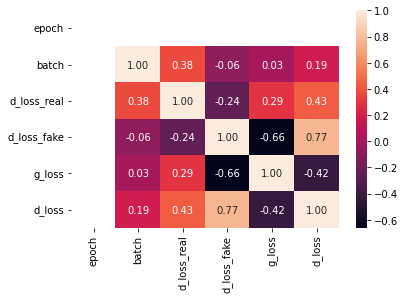

In [4]:
epoch_1 = train_data.loc[train_data['epoch'] == 0]
sb.heatmap(epoch_1.corr(), annot=True, fmt=".2f")

### Epoch 5

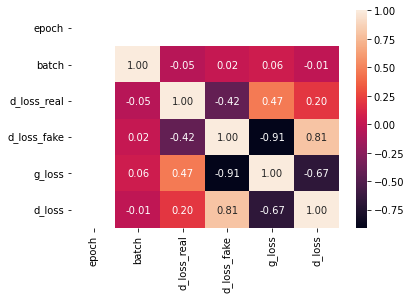

In [5]:
epoch_5 = train_data.loc[train_data['epoch'] == 4]
sb.heatmap(epoch_5.corr(), annot=True, fmt=".2f")

### Epoch 10

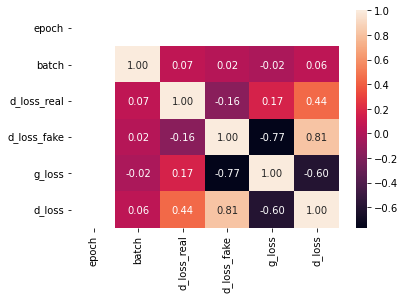

In [6]:
epoch_10 = train_data.loc[train_data['epoch'] == 9]
sb.heatmap(epoch_10.corr(), annot=True, fmt=".2f")

In [7]:
train_data

,epoch,batch,d_loss_real,d_loss_fake,g_loss,d_loss
0,0,0,0.684658,0.697553,0.688655,0.691106
1,0,1,0.615733,0.709038,0.677694,0.662386
2,0,2,0.561204,0.729978,0.659236,0.645591
3,0,3,0.508945,0.761415,0.634786,0.635180
4,0,4,0.439587,0.808618,0.601902,0.624103
...,...,...,...,...,...,...
3895,9,385,0.685502,0.641624,0.757724,0.663563
3896,9,386,0.694672,0.742670,0.738663,0.718671
3897,9,387,0.681642,0.691713,0.746133,0.686678
3898,9,388,0.681012,0.718650,0.772258,0.699831


## Discriminator loss (real/fake) + Generator loss

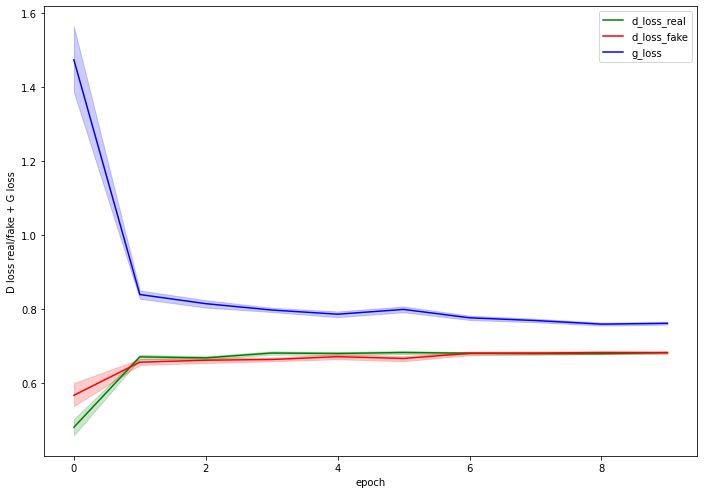

In [8]:
x_col = 'epoch'
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sb.lineplot(x=x_col, y="d_loss_real", data=train_data, color='green')
sb.lineplot(x=x_col, y="d_loss_fake", data=train_data, color='red')
sb.lineplot(x=x_col, y="g_loss", data=train_data, color='blue')
plt.ylabel("D loss real/fake + G loss")
plt.legend(labels=["d_loss_real","d_loss_fake", "g_loss"])
plt.show()

## Discriminator and Generator loss

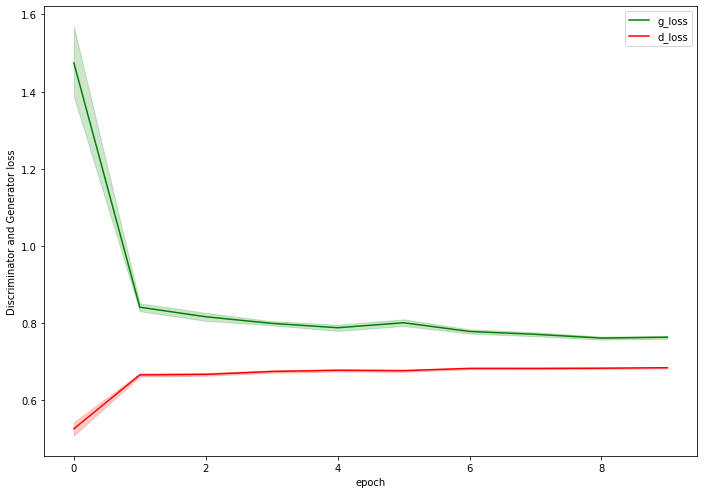

In [9]:
x_col = 'epoch'
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sb.lineplot(x=x_col, y="g_loss", data=train_data, color='green')
sb.lineplot(x=x_col, y="d_loss", data=train_data, color='red')
plt.ylabel("Discriminator and Generator loss")
plt.legend(labels=["g_loss","d_loss"])
plt.show()

## Load the generator model and generate images

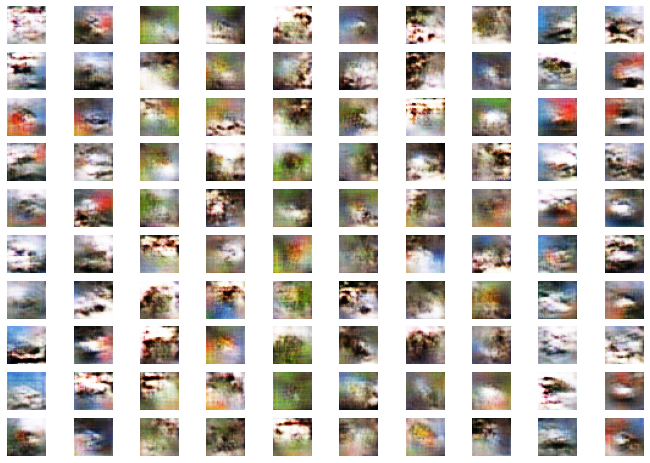

In [28]:
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
import numpy as np

# load model
model = load_model('./{}'.format(MODEL_NAME))
# generate multiple images
latent_points, labels = generate_latent_points(100, 100)
# specify labels - generate 10 sets of labels each gping from 0 to 9
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
X = (X*255).astype(np.uint8)
    
show_plot(X, 10)

In [29]:
labels

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
       4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
       6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
       8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])